### ライブラリ・データの読み込み

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print('train data size =', train_data.shape)
print('test data size =', test_data.shape)

train data size = (1460, 81)
test data size = (1459, 80)


### データ調査

#### 目的変数

In [3]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

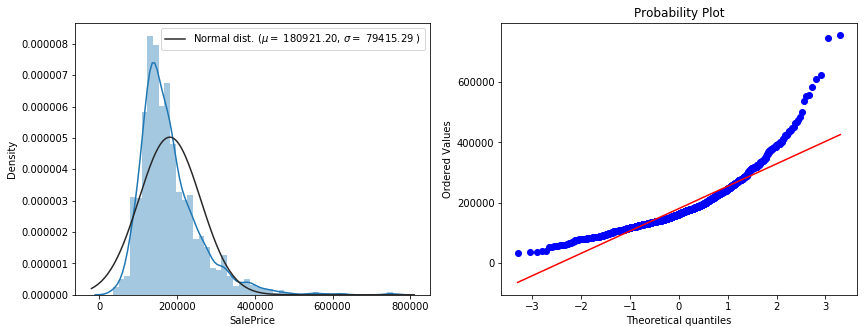

In [4]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.distplot(train_data['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train_data['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f}, $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.xlabel('SalePrice')
plt.ylabel('Density')

plt.subplot(1,2,2)
res = stats.probplot(train_data['SalePrice'], plot=plt)

plt.show()

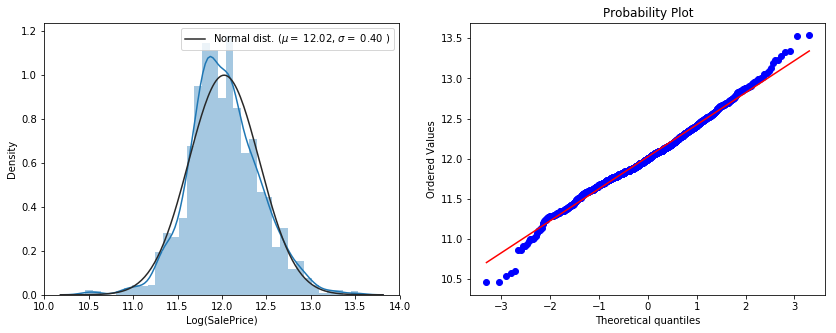

In [5]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.distplot(np.log1p(train_data['SalePrice']), fit=norm)
(mu, sigma) = norm.fit(np.log1p(train_data['SalePrice']))
plt.legend(['Normal dist. ($\mu=$ {:.2f}, $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Density')

plt.subplot(1,2,2)
res = stats.probplot(np.log1p(train_data['SalePrice']), plot=plt)

plt.show()

#### 説明変数の型

In [6]:
for column in train_data.columns:
    print(column, ':', train_data[column].dtype)

Id : int64
MSSubClass : int64
MSZoning : object
LotFrontage : float64
LotArea : int64
Street : object
Alley : object
LotShape : object
LandContour : object
Utilities : object
LotConfig : object
LandSlope : object
Neighborhood : object
Condition1 : object
Condition2 : object
BldgType : object
HouseStyle : object
OverallQual : int64
OverallCond : int64
YearBuilt : int64
YearRemodAdd : int64
RoofStyle : object
RoofMatl : object
Exterior1st : object
Exterior2nd : object
MasVnrType : object
MasVnrArea : float64
ExterQual : object
ExterCond : object
Foundation : object
BsmtQual : object
BsmtCond : object
BsmtExposure : object
BsmtFinType1 : object
BsmtFinSF1 : int64
BsmtFinType2 : object
BsmtFinSF2 : int64
BsmtUnfSF : int64
TotalBsmtSF : int64
Heating : object
HeatingQC : object
CentralAir : object
Electrical : object
1stFlrSF : int64
2ndFlrSF : int64
LowQualFinSF : int64
GrLivArea : int64
BsmtFullBath : int64
BsmtHalfBath : int64
FullBath : int64
HalfBath : int64
BedroomAbvGr : int64
Kitche

#### 説明変数の充足率

In [7]:
null_num = train_data.isnull().sum()
null_ratio = null_num / len(train_data)
null_df = pd.DataFrame({'null_num': null_num, 'null_ratio': null_ratio})
null_df.sort_values(by='null_ratio', ascending=False).head(10)

,null_num,null_ratio
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


#### データ間の相関

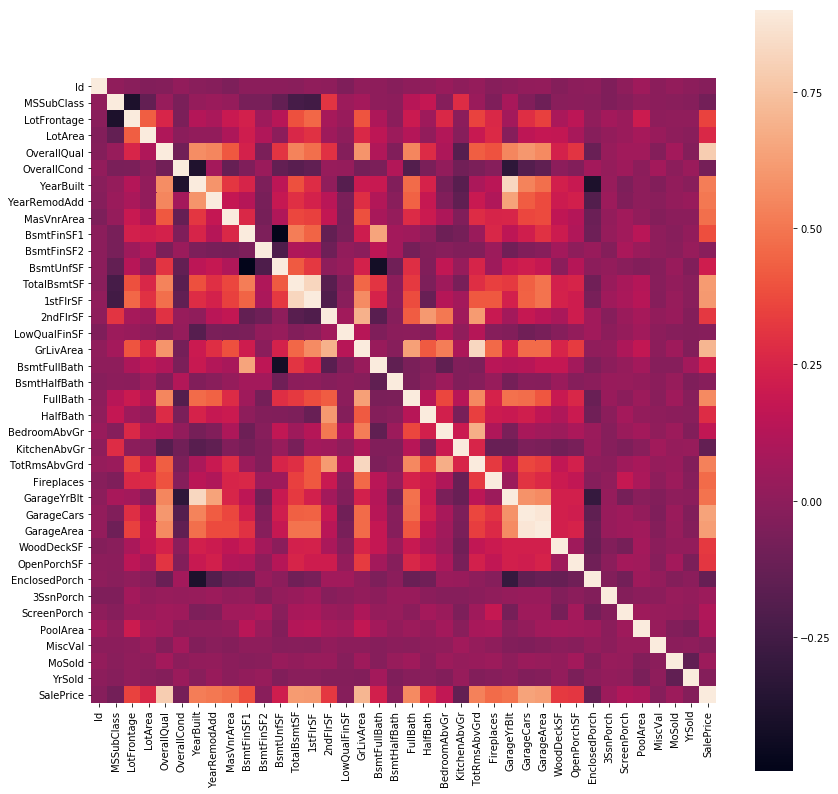

In [8]:
corr_mat = train_data.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr_mat, vmax=0.9, square=True)
plt.show()

### 前処理

#### 外れ値の除去

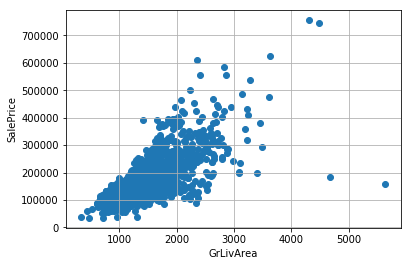

In [9]:
plt.scatter(x=train_data['GrLivArea'], y=train_data['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()

In [10]:
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice'] < 300000)].index)

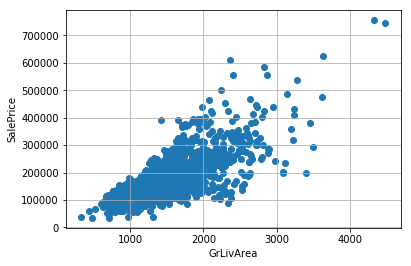

In [11]:
plt.scatter(x=train_data['GrLivArea'], y=train_data['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()

#### 欠損値の補完

In [12]:
train_data_size = len(train_data)
test_data_size = len(test_data)
Y_train = train_data['SalePrice']
Y_train_log = np.log1p(train_data['SalePrice'])
test_id = test_data['Id']

data = pd.concat([train_data, test_data], sort=False).reset_index(drop=True)
data = data.drop(['Id', 'SalePrice'], axis=1)

In [13]:
data['PoolQC'] = data['PoolQC'].fillna('None')
data['MiscFeature'] = data['MiscFeature'].fillna('None')
data['Alley'] = data['Alley'].fillna('None')
data['Fence'] = data['Fence'].fillna('None')
data['FireplaceQu'] = data['FireplaceQu'].fillna('None')
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mode()[0]))
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    data[col] = data[col].fillna('None')
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    data[col] = data[col].fillna(0)
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    data[col] = data[col].fillna(0)
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    data[col] = data[col].fillna('None')
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])
data = data.drop(['Utilities'], axis=1)
data['Functional'] = data['Functional'].fillna('Typ')
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])
data['MSSubClass'] = data['MSSubClass'].fillna('None')

#### Label Encoding

In [14]:
data['MSSubClass'] = data['MSSubClass'].astype(str)
data['OverallCond'] = data['OverallCond'].astype(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']
for col in cols:
    lb = LabelEncoder()
    lb.fit(list(data[col].values))
    data[col] = lb.transform(list(data[col].values))

#### 特徴量の追加

In [15]:
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

#### Box-Cox変換

In [16]:
numeric_features = data.dtypes[data.dtypes != 'object'].index
skewed_features = data[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_df = pd.DataFrame({'Skew': skewed_features})
skew_df.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [17]:
skewed_features = skew_df[abs(skew_df) > 0.75].index
lam = 0.15
for feat in skewed_features:
    data[feat] = boxcox1p(data[feat], lam)

#### ダミー変数化

In [18]:
data = pd.get_dummies(data)

### モデル構築

In [19]:
X_train = data[:train_data_size]
X_test = data[train_data_size:]

print('train data size =', X_train.shape)
print('test data size =', X_test.shape)

train data size = (1458, 220)
test data size = (1459, 220)


In [20]:
sc = RobustScaler()
X_train_std = sc.fit_transform(X_train)

In [21]:
model = Lasso()
parameters = {'alpha': [0.0001*i for i in range(1, 10)], 'random_state':[0]}

grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_std, Y_train_log)

print('best params =', grid.best_params_)
print('best score =', grid.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best params = {'alpha': 0.0005, 'random_state': 0}
best score = -0.012491801087371007


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.3s finished


In [22]:
model = Lasso(**grid.best_params_)
model.fit(X_train_std, Y_train_log)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False)

### モデル検証

In [23]:
Y_pred = model.predict(X_train_std)
np.sqrt(mean_squared_error(y_true=Y_train_log, y_pred=Y_pred))

0.10142578401091346

### 提出データの出力

In [24]:
X_test_std = sc.transform(X_test)
Y_pred = np.expm1(model.predict(X_test_std))

submit_df = pd.DataFrame()
submit_df['Id'] = test_id
submit_df['SalePrice'] = Y_pred
submit_df.to_csv('result.csv', index=False)